<a href="https://colab.research.google.com/github/vinaykumar2491/Project_MachineLearning/blob/master/imflash217_fastai_3_headpose.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!nvidia-smi

Fri Oct 11 11:06:39 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 430.40       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P8    27W / 149W |      0MiB / 11441MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [0]:
from fastai.vision import *

## Getting and converting the data

In [0]:
path = untar_data(URLs.BIWI_HEAD_POSE)

In [6]:
path.ls()

[PosixPath('/root/.fastai/data/biwi_head_pose/07'),
 PosixPath('/root/.fastai/data/biwi_head_pose/10.obj'),
 PosixPath('/root/.fastai/data/biwi_head_pose/18.obj'),
 PosixPath('/root/.fastai/data/biwi_head_pose/15.obj'),
 PosixPath('/root/.fastai/data/biwi_head_pose/18'),
 PosixPath('/root/.fastai/data/biwi_head_pose/10'),
 PosixPath('/root/.fastai/data/biwi_head_pose/19'),
 PosixPath('/root/.fastai/data/biwi_head_pose/17'),
 PosixPath('/root/.fastai/data/biwi_head_pose/06.obj'),
 PosixPath('/root/.fastai/data/biwi_head_pose/02'),
 PosixPath('/root/.fastai/data/biwi_head_pose/21'),
 PosixPath('/root/.fastai/data/biwi_head_pose/01'),
 PosixPath('/root/.fastai/data/biwi_head_pose/14.obj'),
 PosixPath('/root/.fastai/data/biwi_head_pose/01.obj'),
 PosixPath('/root/.fastai/data/biwi_head_pose/16'),
 PosixPath('/root/.fastai/data/biwi_head_pose/23.obj'),
 PosixPath('/root/.fastai/data/biwi_head_pose/11'),
 PosixPath('/root/.fastai/data/biwi_head_pose/06'),
 PosixPath('/root/.fastai/data/biwi_

In [11]:
calib = np.genfromtxt(fname=path/"01"/"rgb.cal", skip_footer=6)
calib

array([[517.679,   0.   , 320.   ],
       [  0.   , 517.679, 240.5  ],
       [  0.   ,   0.   ,   1.   ]])

In [0]:
fname = "09/frame_00667_rgb.jpg"

In [0]:
def img2txt_name(fname):
    return path/f"{str(fname)[:-7]}pose.txt"

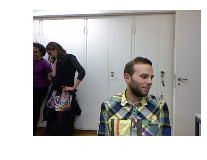

In [14]:
img = open_image(path/fname)
img.show()

In [28]:
center = np.genfromtxt(img2txt_name(fname=fname), skip_header=3)
center

array([187.332 ,  40.3892, 893.135 ])

In [0]:
def convert_biwi(coordinates):
    c1 = coordinates[0] * calib[0][0]/coordinates[2] + calib[0][2]
    c2 = coordinates[1] * calib[1][1]/coordinates[2] + calib[1][2]
    return tensor([c2, c1])     ## NOTE: its [c2, c1] not [c1, c2]

def get_center(fname):
    center = np.genfromtxt(img2txt_name(fname=fname), skip_header=3)
    return convert_biwi(coordinates=center)

def get_ip(img, pts):
    """Get the image points"""
    return ImagePoints(FlowField(img.size, pts), scale=True)

In [30]:
get_center(fname=fname)

tensor([263.9104, 428.5814])

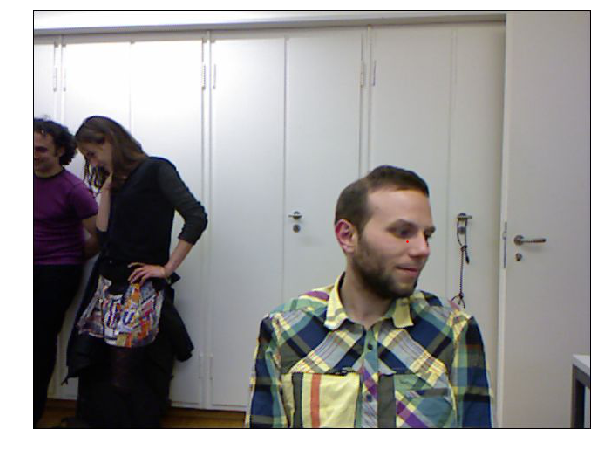

In [32]:
center = get_center(fname)
img.show(y=get_ip(img=img, pts=center), figsize=(10,10))

## Creating the dataset

In [0]:
bs=8

In [0]:
data = (PointsItemList.from_folder(path)
        .split_by_valid_func(lambda o: o.parent.name == "13")
        .label_from_func(get_center)
        .transform(tfms=get_transforms(), tfm_y=True, size=(120, 160))
        .databunch(bs=bs)
        .normalize(imagenet_stats)
        )

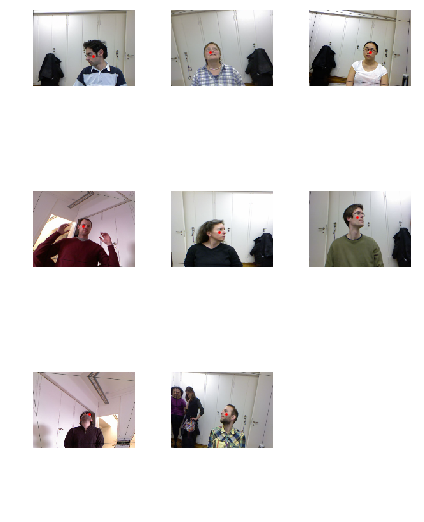

In [38]:
data.show_batch(rows=3, figsize=(6,8))

## Train the model

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/checkpoints/resnet34-333f7ec4.pth
100%|██████████| 83.3M/83.3M [00:03<00:00, 26.0MB/s]


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


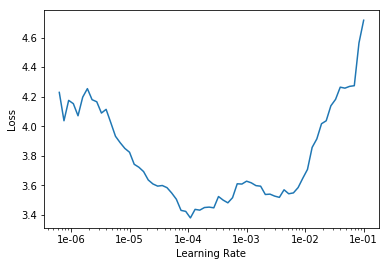

In [39]:
learner = cnn_learner(data=data, base_arch=models.resnet34)
learner.lr_find()
learner.recorder.plot()

In [0]:
lr = 1e-5

In [41]:
learner.fit_one_cycle(cyc_len=4, max_lr=slice(lr))

epoch,train_loss,valid_loss,time
0,3.244787,0.280207,04:23
1,2.589597,0.200550,04:22
2,2.363202,0.259998,04:22
3,2.438337,0.273987,04:23


In [0]:
learner.save("resnet34_stage1")

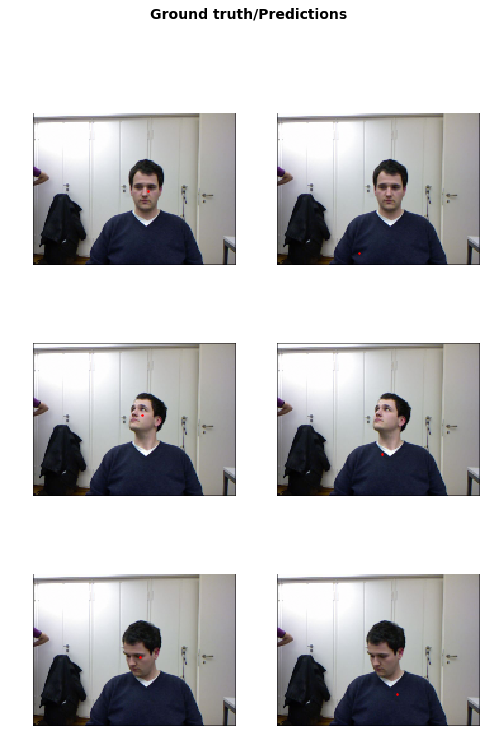

In [43]:
learner.show_results(rows=3)

In [44]:
learner.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


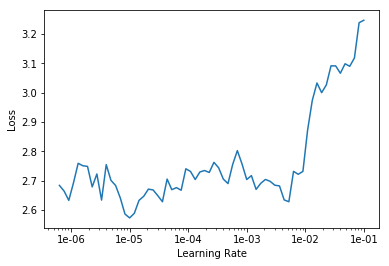

In [45]:
learner.recorder.plot()

In [0]:
lrs = slice(5e-6, 1e-3)

In [47]:
learner.fit_one_cycle(cyc_len=4, max_lr=lrs)

epoch,train_loss,valid_loss,time
0,0.035816,0.005310,04:21
1,0.024710,0.008452,04:24
2,0.014769,0.003967,04:24
3,0.011862,0.002544,04:26


## Data Augmentation

In [0]:
tfms = get_transforms(max_rotate=20, max_zoom=1.5, max_lighting=0.5, max_warp=0.4, p_affine=1., p_lighting=1.)

data = (PointsItemList.from_folder(path)
        .split_by_valid_func(lambda o: o.parent.name=="13")
        .label_from_func(get_center)
        .transform(tfms=tfms, tfm_y=True, size=(120,160))
        .databunch(bs=bs)
        .normalize(imagenet_stats)
        )

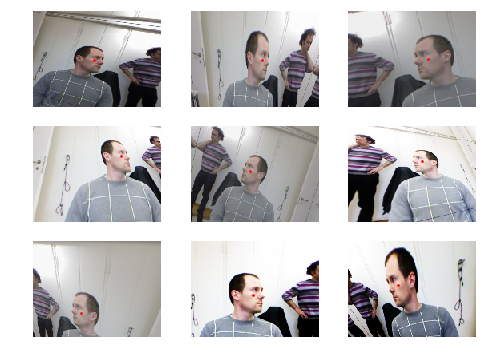

In [52]:
def _plot(i, j, ax):
    x, y = data.train_ds[0]
    x.show(ax, y=y)

plot_multi(func=_plot, r=3, c=3, figsize=(8,6))

In [0]:
## Training model
learner = cnn_learner(data=data, base_arch=models.resnet34)

In [57]:
learner.fit_one_cycle(cyc_len=1, max_lr=slice(lr))

epoch,train_loss,valid_loss,time


RuntimeError: ignored

In [55]:
learner.lr_find()
learner.recorder.plot()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


RuntimeError: ignored

In [56]:
!nvidia-smi

Fri Oct 11 13:52:14 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 430.40       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   58C    P0    63W / 149W |    689MiB / 11441MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  